# GANs

- Adapted from: https://www.tensorflow.org/beta/tutorials/generative/dcgan

## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

## Loading and pre-processing the dataset

In [2]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
28 * 28

784

In [5]:
y_train.shape

(60000,)

3


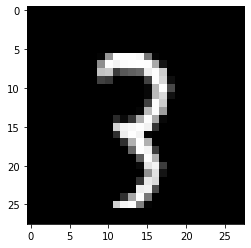

In [7]:
i = np.random.randint(0, 60000)
print(y_train[i])
plt.imshow(X_train[i], cmap='gray');

In [8]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [9]:
X_train.shape

(60000, 28, 28, 1)

In [10]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

In [11]:
# X_train = X_train / 255
X_train = (X_train - 127.5) / 127.5

In [12]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [13]:
buffer_size = 60000
batch_size = 256

In [14]:
buffer_size / batch_size

234.375

In [15]:
type(X_train)

numpy.ndarray

In [16]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [17]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [18]:
X_train

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

## Building the generator

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Activation functions: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [19]:
def build_generator():
    network = tf.keras.Sequential()

    network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    network.add(layers.Reshape((7, 7, 256)))

    # 7x7x128
    network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    # 14x14x64
    network.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    # 28x28x1
    network.add(layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding='same', use_bias=False, activation='tanh'))

    network.summary()

    return network

In [20]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [21]:
noise = tf.random.normal([1, 100])

In [22]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.1361513 , -2.4278162 ,  1.2450174 ,  1.1554264 ,  0.5245524 ,
         0.59623265, -0.76014763,  0.03096815,  1.6274943 , -0.02355172,
         1.8248216 , -0.83588123,  1.1582174 ,  0.20050514,  1.1010066 ,
         0.21099055,  0.4050939 , -1.4266539 ,  0.4213434 ,  2.0026817 ,
         1.2536294 ,  1.0963975 ,  0.6866597 ,  1.8969723 , -0.06791132,
        -0.6501335 ,  0.55985826, -0.51598513, -1.6963601 , -0.5488256 ,
        -1.2946078 , -0.59211653, -0.49406338,  1.9742764 ,  1.3849828 ,
        -1.7608474 ,  1.4141303 ,  1.6290275 ,  0.3946384 , -0.8087963 ,
        -0.52180594,  0.9291495 , -0.04668184, -0.03267781,  0.26187772,
        -0.88641226,  1.1414785 ,  0.49954522,  0.8022558 ,  0.48896518,
        -0.3681712 ,  0.8292825 ,  0.02837218, -0.25923073,  0.4017445 ,
        -0.6720189 , -0.04123277,  1.1304406 ,  1.3639448 ,  2.7413645 ,
        -0.45089987,  0.20497923,  1.2176634 , -1.6982198 , -0.7715941 ,
 

In [23]:
generated_image = generator(noise, training = False)

In [24]:
generated_image.shape

TensorShape([1, 28, 28, 1])

In [33]:
generated_image[0,:,:,0].shape

TensorShape([28, 28])

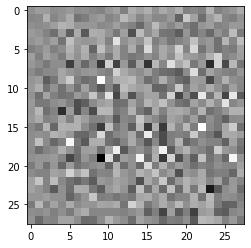

In [34]:
plt.imshow(generated_image[0,:,:,0], cmap='gray');

## Building the discriminator

- Dropout: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

In [26]:
def build_discriminator():
    network = tf.keras.Sequential()

    # 14x14x64
    network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    # 7x7x128
    network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    network.add(layers.Flatten())
    network.add(layers.Dense(1))

    network.summary()

    return network

In [27]:
7 * 7 * 128

6272

In [28]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [29]:
discriminator(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00030515]], dtype=float32)>

## Calculating the loss

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [35]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [36]:
def discriminator_loss(expected_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [37]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

## Training the model

In [ ]:
X_train

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [39]:
epochs = 100
noise_dim = 100
num_images_to_generate = 16

In [40]:
batch_size, noise_dim

(256, 100)

In [41]:
@tf.function
def train_steps(images):
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        expected_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(expected_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [42]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])

In [43]:
test_images.shape

TensorShape([16, 100])

In [46]:
def train(dataset, epochs, test_images):
    for epoch in range(epochs):
        for image_batch in dataset:
            #print(image_batch.shape)
            train_steps(image_batch)
            
        if ((epoch+1) % 10 == 0):
            print('Epoch: ', epoch + 1)
            generated_images = generator(test_images, training = False)
            fig = plt.figure(figsize=(10,10))
            for i in range(generated_images.shape[0]):
                plt.subplot(4,4,i+1)
                plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
                plt.axis('off')
            plt.show()

Epoch:  10


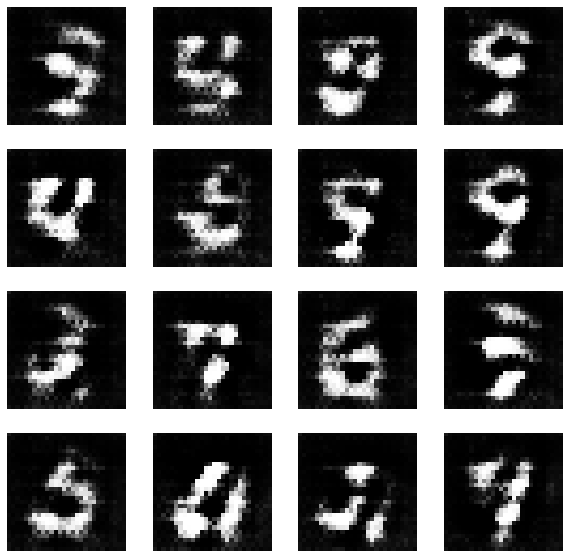

Epoch:  20


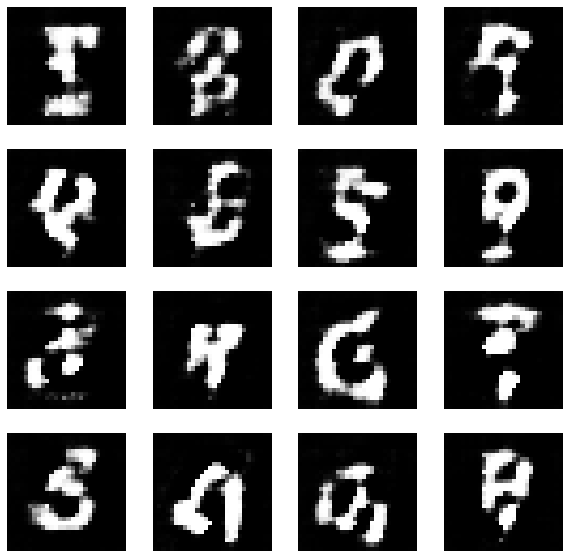

Epoch:  30


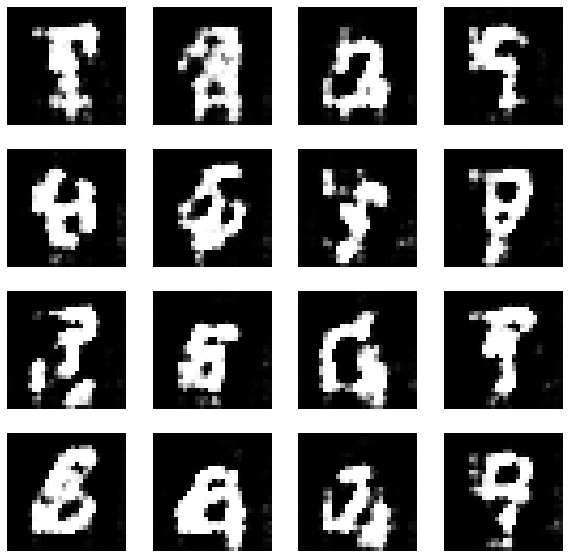

Epoch:  40


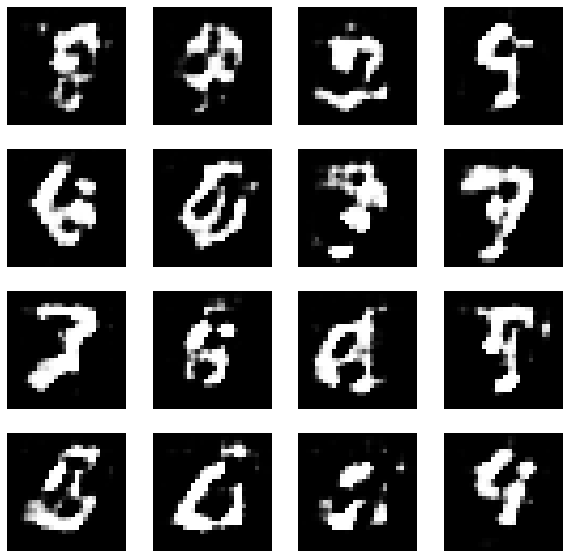

KeyboardInterrupt: 

In [47]:
train(X_train, epochs, test_images)